In [1]:
import copy
import numpy as np
from tqdm import tqdm

import pickle
import torch

from update import LocalUpdate, test_inference
from models import CNNMnist, CNNCifar
from utils import *

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [2]:
n_train_epochs = 60
n_train_clients = 50
n_total_clients = 500


mal_usr_percentage = 0
target_hon = 3
target_mal = 8

# dataset = 'mnist'
dataset = 'cifar'
client_lr = 0.001
client_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
# torch.cuda.set_device('cuda:0')
# print(torch.cuda.set_device('cuda'))
# print(torch.cuda.set_device(0))
# device = 'cuda'

mal = [0, 10, 20, 30, 40]


NVIDIA GeForce GTX 1080 Ti


In [3]:
# load dataset and user groups
train_dataset, test_dataset, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, dataset)

# Training
clients = []
for i in range(n_train_epochs):
    clients.append(np.random.choice(range(n_total_clients), n_train_clients, replace=False))
    # clients.append(range(n_total_clients)[:n_train_clients])

train_loss_total = []
train_accuracy_total = []
train_recall_total = []

test_loss_total = []
test_accuracy_total = []
test_recall_total = []

attacker_detection_ratio = []

# if dataset == 'mnist':
#     global_model = CNNMnist()
# elif dataset == 'cifar':
#     global_model = CNNCifar()

# # Saving:
# torch.save({
#     'model': global_model,
# }, 'cifar100.pth')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
attack = [0, 1]
recalls = []

mal = [0, 10, 20, 30, 40, 50]

## Just for training honest model

In [4]:
mal_usr_percentage = 0

checkpoint = torch.load('cifar.pth')
global_model = checkpoint['model']
global_model.load_state_dict(global_model.state_dict())

train_accuracy = []
train_recall = []

# load dataset and user groups
train_dataset, test_dataset, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, dataset)

# Training
clients = []
for i in range(n_train_epochs):
    clients.append(np.random.choice(range(n_total_clients), n_train_clients, replace=False))


# Send the model to the device and then set it to train mode
global_model.to(device)
global_model.train() 

# hold the initial global weights
global_weights = global_model.state_dict()
# just attacks
for epoch in tqdm(range(n_train_epochs)):

    selected_users = clients[epoch]
        
    local_weights, local_losses = [], []
    
    for user in selected_users:
        local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

        w, loss = local_model.update_weights(
            model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr)
        
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))
    
    loss_avg = sum(local_losses) / len(selected_users)
    
    train_loss_total.append(loss_avg)
    
    # update global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    # Calculate avg training accuracy over all users at every epoch
    train_acc = 0
    train_rec = 0
    # evaluation mode of the model
    global_model.eval()

    for client in selected_users:
        local_model = LocalUpdate(dataset = train_dataset, clients = user_groups[client])
        
        acc, loss, rec = local_model.inference(model = global_model)
        train_acc += acc
        train_rec += rec
        
    train_acc /= len(selected_users)
    train_rec /= len(selected_users)
    print(train_acc)
    train_accuracy.append(train_acc)
    train_recall.append(train_rec)

Files already downloaded and verified


Files already downloaded and verified


  3%|▎         | 1/30 [00:40<19:28, 40.30s/it]

0.07066666666666668


  7%|▋         | 2/30 [01:23<19:34, 41.96s/it]

0.1


 10%|█         | 3/30 [02:05<18:53, 41.99s/it]

0.12000000000000005


 13%|█▎        | 4/30 [02:47<18:16, 42.19s/it]

0.15466666666666673


 17%|█▋        | 5/30 [03:30<17:41, 42.44s/it]

0.16266666666666668


 20%|██        | 6/30 [04:12<16:55, 42.30s/it]

0.18399999999999994


 23%|██▎       | 7/30 [04:55<16:18, 42.54s/it]

0.18000000000000005


 27%|██▋       | 8/30 [05:38<15:35, 42.50s/it]

0.16266666666666668


 30%|███       | 9/30 [06:21<14:54, 42.62s/it]

0.19333333333333336


 33%|███▎      | 10/30 [07:04<14:19, 42.99s/it]

0.19333333333333327


 37%|███▋      | 11/30 [07:45<13:22, 42.22s/it]

0.2146666666666666


 40%|████      | 12/30 [08:21<12:03, 40.21s/it]

0.21466666666666676


 43%|████▎     | 13/30 [08:55<10:53, 38.43s/it]

0.2240000000000001


 47%|████▋     | 14/30 [09:29<09:52, 37.03s/it]

0.20800000000000002


 50%|█████     | 15/30 [09:59<08:46, 35.10s/it]

0.26533333333333337


 53%|█████▎    | 16/30 [10:29<07:47, 33.40s/it]

0.2106666666666667


 57%|█████▋    | 17/30 [10:58<06:57, 32.10s/it]

0.24400000000000002


 60%|██████    | 18/30 [11:29<06:20, 31.73s/it]

0.23600000000000004


 63%|██████▎   | 19/30 [11:58<05:41, 31.04s/it]

0.2346666666666667


 67%|██████▋   | 20/30 [12:37<05:34, 33.45s/it]

0.2386666666666666


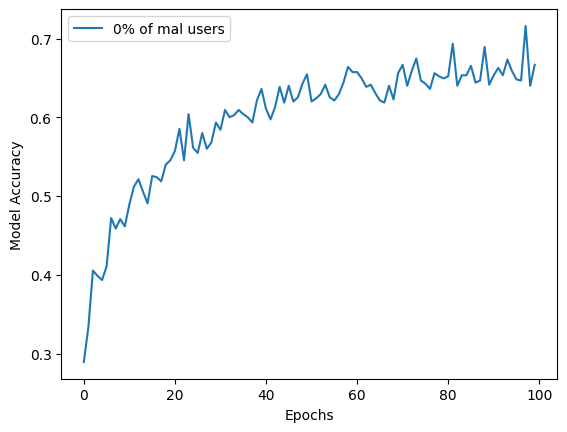

In [ ]:
plt.plot(range(n_train_epochs), train_accuracy, label = str(0) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
# plt.ylim(0, 1)

plt.legend()
plt.show()

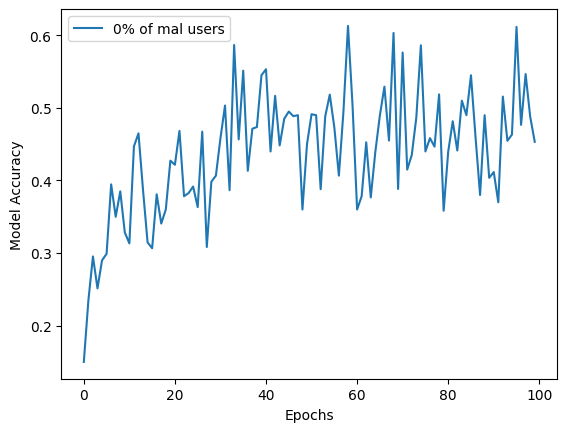

In [ ]:
plt.plot(range(n_train_epochs), train_recall, label = str(0) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

In [ ]:
# test_acc, test_ls, test_rec = test_inference(global_model, test_dataset)
print(test_inference(global_model, test_dataset))

(0.6724, 1.070690012430843, 0.491999508000492)


## Just for attack with many mal%

In [5]:
# load dataset and user groups
train_dataset, test_dataset, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, dataset)

# Training
clients = []
for i in range(n_train_epochs):
    clients.append(np.random.choice(range(n_total_clients), n_train_clients, replace=False))



# train_loss_total = []
# train_accuracy_total = []
# train_recall_total = []

# test_loss_total = []
# test_accuracy_total = []
# test_recall_total = []

for mal_usr_percentage in mal:
    
    train_dataset, _, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, dataset)

    checkpoint = torch.load('../mnist.pth')
    global_model = checkpoint['model']
    global_model.load_state_dict(global_model.state_dict())

    attack_ratio = 0
    
    print("Running experiment with " + str(mal_usr_percentage) + "% malicious clients")

    # Send the model to the device and then set it to train mode
    global_model.to(device)
    global_model.train()

    # hold the initial global weights
    global_weights = global_model.state_dict()
    
    train_loss , train_accuracy, train_recall = [], [], []
    test_loss , test_accuracy, test_recall = [], [], []


    for epoch in tqdm(range(n_train_epochs)):
        selected_users = clients[epoch]
            
        local_weights, local_losses = [], []
        
        for user in selected_users:
            local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

            w, loss = local_model.update_weights(
                model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr)
            
            local_weights.append(copy.deepcopy(w))
            local_losses.append(copy.deepcopy(loss))
        
        loss_avg = sum(local_losses) / len(selected_users)
        
        train_loss_total.append(loss_avg)
        
        # update global weights
        global_weights = average_weights(local_weights)
        # update global weights
        global_model.load_state_dict(global_weights)

        # Calculate avg training accuracy over all users at every epoch
        train_acc = 0
        train_rec = 0
        # evaluation mode of the model
        global_model.eval()

        for client in selected_users:
            local_model = LocalUpdate(dataset = train_dataset, clients = user_groups[client])
            
            acc, loss, rec = local_model.inference(model = global_model)
            train_acc += acc
            train_rec += rec
            
        train_acc /= len(selected_users)
        train_rec /= len(selected_users)
        
        train_accuracy.append(train_acc)
        train_recall.append(train_rec)

        # Test inference after each epoch
        test_acc, test_ls, test_rec = test_inference(global_model, test_dataset)

        test_accuracy.append(test_acc)
        test_loss.append(test_ls)
        test_recall.append(test_rec)   
    
    test_accuracy_total.append(test_accuracy)    
    test_loss_total.append(test_loss)    
    test_recall_total.append(test_recall)    


Running experiment with 0% malicious clients


100%|██████████| 30/30 [07:29<00:00, 14.98s/it]


Running experiment with 10% malicious clients


100%|██████████| 30/30 [08:10<00:00, 16.35s/it]


Running experiment with 20% malicious clients


100%|██████████| 30/30 [06:30<00:00, 13.00s/it]


Running experiment with 30% malicious clients


100%|██████████| 30/30 [07:14<00:00, 14.48s/it]


Running experiment with 40% malicious clients


100%|██████████| 30/30 [08:35<00:00, 17.17s/it]


Running experiment with 50% malicious clients


100%|██████████| 30/30 [07:36<00:00, 15.20s/it]


In [12]:
print(test_recall)

[0.002999997000003, 0.009999990000010001, 0.048999951000049, 0.046999953000047, 0.135999864000136, 0.180999819000181, 0.164999835000165, 0.305999694000306, 0.27999972000028, 0.35999964000036, 0.343999656000344, 0.41399958600041403, 0.416999583000417, 0.41599958400041603, 0.434999565000435, 0.41999958000042004, 0.428999571000429, 0.448999551000449, 0.421999578000422, 0.380999619000381, 0.437999562000438, 0.383999616000384, 0.382999617000383, 0.444999555000445, 0.428999571000429, 0.45999954000046, 0.425999574000426, 0.45899954100045903, 0.46299953700046304, 0.451999548000452, 0.46699953300046704, 0.485999514000486, 0.473999526000474, 0.461999538000462, 0.453999546000454, 0.472999527000473, 0.432999567000433, 0.45899954100045903, 0.488999511000489, 0.46499953500046504, 0.483999516000484, 0.483999516000484, 0.47999952000048, 0.487999512000488, 0.496999503000497, 0.498999501000499, 0.494999505000495, 0.488999511000489, 0.45699954300045703, 0.491999508000492, 0.503999496000504, 0.49499950500

In [6]:
import pickle

with open('attack_minst_lists.pkl', 'wb') as file:
    pickle.dump([test_accuracy_total, test_loss_total, test_recall_total], file)

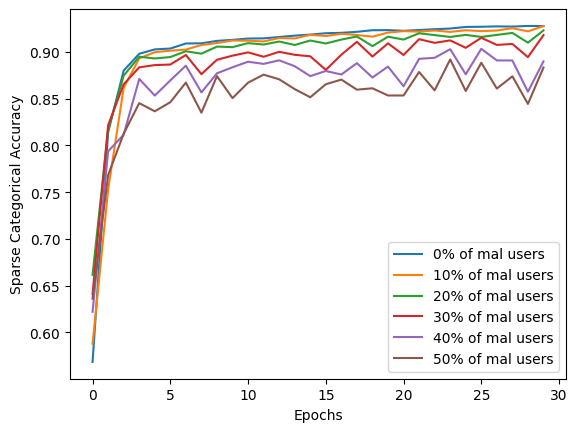

In [7]:
#plot for only attacking
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(test_accuracy_total):

    plt.plot(epochs, model_acc, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Sparse Categorical Accuracy")
plt.legend()
plt.show()

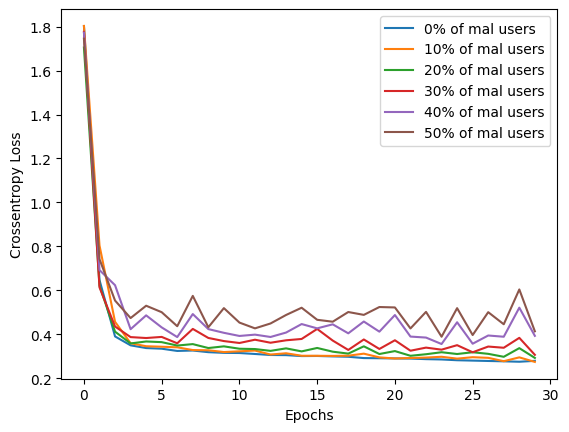

In [8]:
#plot for only attacking
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(test_loss_total):

    plt.plot(epochs, model_loss, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Crossentropy Loss")
plt.legend()
plt.show()

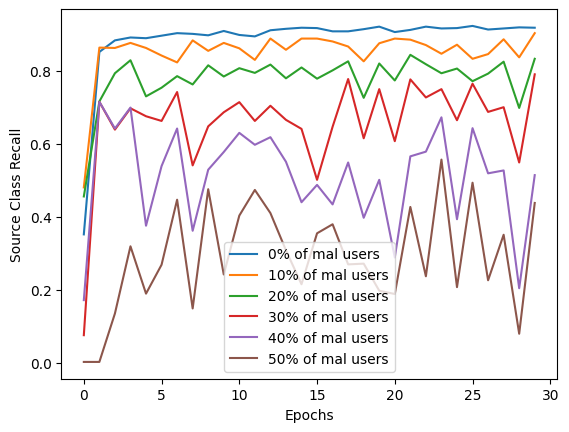

In [9]:
#plot for only attacking
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_rec in enumerate(test_recall_total):

    plt.plot(epochs, model_rec, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")
plt.legend()
plt.show()

## Defense applied 

In [4]:
attacker_detection_ratio = []
train_loss_total = []
train_accuracy_total = []
train_recall_total = []

test_loss_total = []
test_accuracy_total = []
test_recall_total = []

attackers_accuracy_total = []
attackers_f1_total = []

In [7]:
attack = [1]
recalls = []

mal = [10, 20, 30, 40]

for att in attack:
    last_epoch_recall = []

    for mal_usr_percentage in mal:
        
        train_dataset, _, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, dataset)

        checkpoint = torch.load('cifar.pth')
        global_model = checkpoint['model']
        global_model.load_state_dict(global_model.state_dict())

        attack_ratio = 0
        
        print("Running experiment with " + str(mal_usr_percentage) + "% malicious clients")

        # Send the model to the device and then set it to train mode
        global_model.to(device)
        global_model.train()
    
        # hold the initial global weights
        global_weights = global_model.state_dict()
        
        train_loss , train_accuracy, train_recall = [], [], []
        test_loss , test_accuracy, test_recall = [], [], []

        attackers_accuracy, attackers_f1 = [], []

        for epoch in tqdm(range(n_train_epochs)):
            if att == 1:
                local_weights_fake, local_losses_fake = [], []
                
                global_model.train()
            
                selected_users = clients[epoch]

                for user in selected_users:
                    local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

                    w, loss = local_model.update_weights(
                        model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr, fake=True)
                    
                    local_weights_fake.append(copy.deepcopy(w))
                    local_losses_fake.append(copy.deepcopy(loss))

                
                local_losses_fake = apply_ldp(local_losses_fake, epsilon=1.0, sensitivity=0.0001)
                
                info = (local_losses_fake, local_weights_fake, selected_users)
                
                selected_users, attackers_found = eliminate_kmeans(info)
                            
                count = sum(1 for item in attackers_found if item in attackers)
                
                if mal_usr_percentage > 0 and att == 1:
                    attack_ratio += (count / ((mal_usr_percentage / 100) * n_train_clients))
                    
                    attackers_accuracy = calculate_accuracy(attackers_found, attackers, selected_users)
                    attackers_recall = calculate_f1_score(attackers_found, attackers)
                    
                    
            elif att == 0:
                selected_users = clients[epoch]
                
            local_weights, local_losses = [], []
            
            for user in selected_users:
                local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

                w, loss = local_model.update_weights(
                    model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr)
                
                local_weights.append(copy.deepcopy(w))
                local_losses.append(copy.deepcopy(loss))
            
            loss_avg = sum(local_losses) / len(selected_users)
            
            train_loss_total.append(loss_avg)
            
            # update global weights
            global_weights = average_weights(local_weights)
            # update global weights
            global_model.load_state_dict(global_weights)

            # Calculate avg training accuracy over all users at every epoch
            train_acc = 0
            train_rec = 0
            # evaluation mode of the model
            global_model.eval()

            for client in selected_users:
                local_model = LocalUpdate(dataset = train_dataset, clients = user_groups[client])
                
                acc, loss, rec = local_model.inference(model = global_model)
                train_acc += acc
                train_rec += rec
                
            train_acc /= len(selected_users)
            train_rec /= len(selected_users)
            
            train_accuracy.append(train_acc)
            train_recall.append(train_rec)

            # # Test inference after each epoch
            # test_acc, test_ls, test_rec = test_inference(global_model, test_dataset)

            # test_accuracy.append(test_acc)
            # test_loss.append(test_ls)
            # test_recall.append(test_rec)
            
        
        # last_epoch_recall.append(test_recall[-1])
        
        if att == 1:
            attack_ratio /= n_train_epochs
            if attack_ratio > 1:
                attack_ratio = 1
                
            if mal_usr_percentage > 0:
                attackers_accuracy_total.append(attackers_accuracy)
                attackers_f1_total.append(attackers_f1)
                
    #         attacker_detection_ratio.append(attack_ratio)
    #         train_accuracy_total.append(train_accuracy)
    #         train_loss_total.append(train_loss)
    #         train_recall_total.append(train_recall)

    #         test_accuracy_total.append(test_accuracy)
    #         test_loss_total.append(test_loss)
    #         test_recall_total.append(test_recall)

    # recalls.append(last_epoch_recall)


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 10% malicious clients


100%|██████████| 60/60 [46:48<00:00, 46.81s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 20% malicious clients


100%|██████████| 60/60 [44:15<00:00, 44.26s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 30% malicious clients


100%|██████████| 60/60 [44:01<00:00, 44.02s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 40% malicious clients


100%|██████████| 60/60 [41:02<00:00, 41.05s/it]


In [12]:
print(recalls)

[[0.56999943000057, 0.542999457000543, 0.560999439000561, 0.574999425000575, 0.578999421000579]]


In [16]:
print(len(attackers_found))


33


ValueError: x and y must have same first dimension, but have shapes (60,) and (0,)

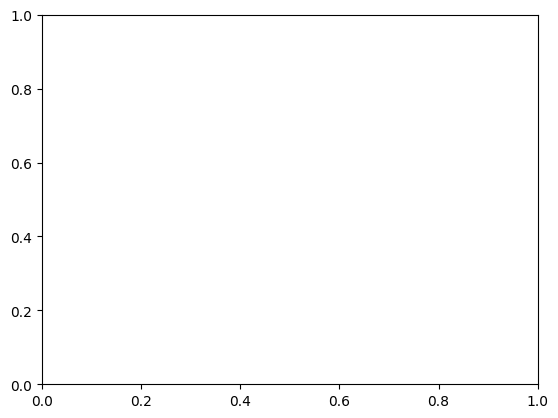

In [8]:
#plot for only attacking
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(attackers_f1_total):

    plt.plot(epochs, model_acc, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Sparse Categorical Accuracy")
plt.legend()
plt.show()

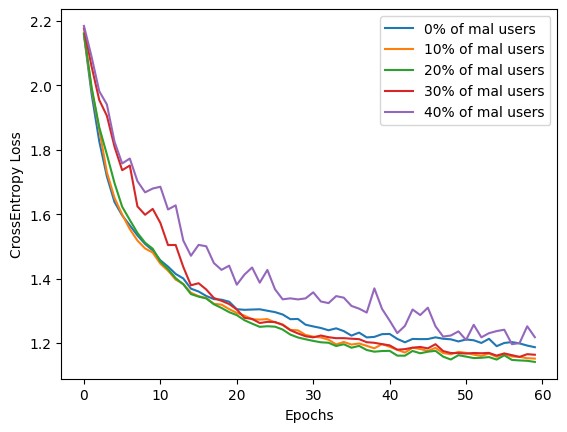

In [21]:
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(test_loss_total):

    plt.plot(epochs, model_loss, label = str(mal[cnt]) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.show()

In [5]:
with open('defense_cifar_lists.pkl', 'rb') as file:
    test_accuracy_total, test_loss_total, test_recall_total = pickle.load(file)

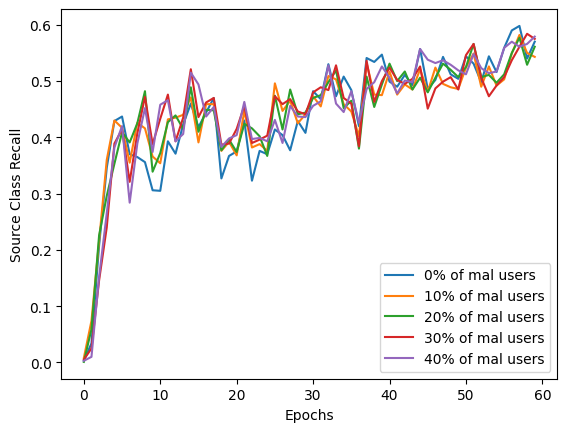

In [11]:
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_rec in enumerate(test_recall_total):

    plt.plot(epochs, model_rec, label = str(mal[cnt]) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")
plt.legend()
plt.show()

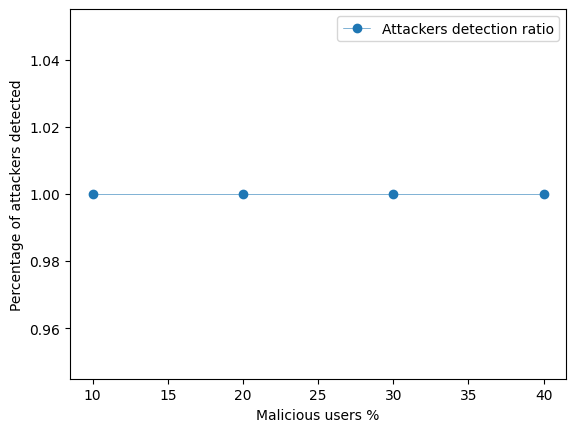

In [23]:
plt.figure()

plt.plot(mal[1:], attacker_detection_ratio[1:], 'o',  label = "Attackers detection ratio", linestyle = "-", linewidth = .4)
plt.xlabel("Malicious users %")
plt.ylabel("Percentage of attackers detected")
plt.legend()
plt.show()

In [24]:
with open('attack_cifar_lists.pkl', 'rb') as file:
    _, _, attack_recalls = pickle.load(file)

In [36]:
with open('recalls_last_epoch_cifar.pkl', 'wb') as file:
    pickle.dump(recalls, file)

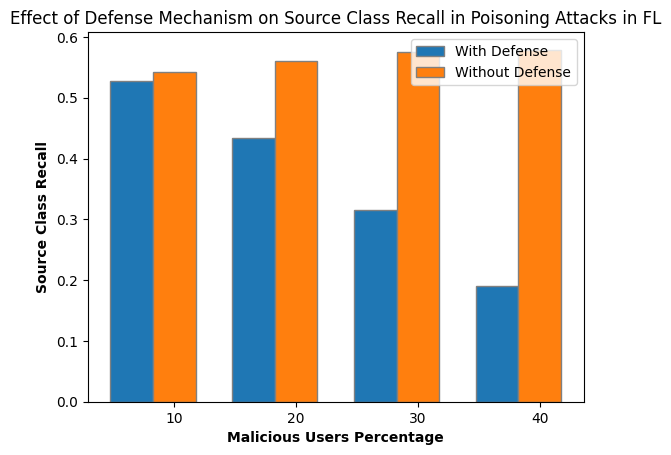

In [35]:
plt.figure()
bar_width = 0.35

r1 = np.arange(len(mal[1:]))
r2 = [x + bar_width for x in r1]

plt.bar(r1, recalls[0][1:], width=bar_width, edgecolor='grey', label='With Defense')
plt.bar(r2, recalls[1][1:], width=bar_width, edgecolor='grey', label='Without Defense')

plt.title('Effect of Defense Mechanism on Source Class Recall in Poisoning Attacks in FL')
plt.xlabel('Malicious Users Percentage', fontweight='bold')
plt.ylabel('Source Class Recall', fontweight='bold')

plt.xticks([r + bar_width for r in range(len(recalls[0][1:]))], mal[1:])

plt.legend()
plt.show()